In [ ]:
!python -m site

sys.path = [
    '/mnt/c/Windows/system32',
    '/home/ubuntu-marcelo/miniconda3/envs/rapids-23.08/lib/python310.zip',
    '/home/ubuntu-marcelo/miniconda3/envs/rapids-23.08/lib/python3.10',
    '/home/ubuntu-marcelo/miniconda3/envs/rapids-23.08/lib/python3.10/lib-dynload',
    '/home/ubuntu-marcelo/miniconda3/envs/rapids-23.08/lib/python3.10/site-packages',
]
USER_BASE: '/home/ubuntu-marcelo/.local' (exists)
USER_SITE: '/home/ubuntu-marcelo/.local/lib/python3.10/site-packages' (doesn't exist)
ENABLE_USER_SITE: True


In [ ]:
# !pip install \
#     --extra-index-url=https://pypi.nvidia.com \
#     cuml-cu11

In [ ]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Mon_Oct_24_19:12:58_PDT_2022
Cuda compilation tools, release 12.0, V12.0.76
Build cuda_12.0.r12.0/compiler.31968024_0


In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
google_id = '1teoxduT3bJAkrD0k1YIPn-mbVI83oQox'
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id=google_id,
                                    dest_path = './dados_cvm.csv',
                                    showsize = True)


google_id = '1J0fF-82tDg70wjaNg2Q8OGxPikA7phqp'
gdd.download_file_from_google_drive(file_id=google_id,
                                    dest_path = './dados_classes.csv',
                                    showsize = True)


google_id = '12Ior9IH6xpACUIP0qRWCvGNRs9774150'
gdd.download_file_from_google_drive(file_id=google_id,
                                    dest_path = './synthetic_data_realistic.csv',
                                    showsize = True)

In [ ]:
df_1 = pd.read_csv('dados_cvm.csv')
df_2 = pd.read_csv('dados_classes.csv')
df = pd.merge(df_1, df_2, on='SK_Documento', how='inner')

/tmp/ipykernel_6709/529873874.py:1: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv('dados_cvm.csv')


# Passo 1: Agregar cotas em Subordinadas e Senior por fundo

In [ ]:
print(f"{len(df.loc[df['Patrimonio_Liquido'] == 0]) / len(df.index) * 100}% dos fundos tem PL == 0")

1.281484012254751% dos fundos tem PL == 0


In [ ]:
print(f"{len(df.loc[df['Patrimonio_Liquido'] < 0]) / len(df.index) * 100}% dos fundos tem PL < 0")

0.09073444492363185% dos fundos tem PL < 0


In [ ]:
print(f"Pré-operação tinhamos {len(df.columns)} colunas e {len(df.index)} linhas")
print(f"Pré-operação tinhamos {df['Classe_Serie'].nunique()} dados únicos na coluna Classe_Serie")

df.loc[df['Classe_Serie'].str.contains("sub", case=False), 'Classe_Serie'] = "Subordinada"
df.loc[df['Classe_Serie'].str.contains("nior", case=False), 'Classe_Serie'] = "Senior"

print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")
print(f"Agora temos {df['Classe_Serie'].nunique()} dados únicos na coluna Classe_Serie")


Pré-operação tinhamos 336 colunas e 178543 linhas
Pré-operação tinhamos 57 dados únicos na coluna Classe_Serie
Agora temos 336 colunas e 178543 linhas
Agora temos 2 dados únicos na coluna Classe_Serie


In [ ]:
# Agora vamos criar colunas agregando as 'cols_to_sum' por Subordinada e Senior
classe_serie_types = ["Subordinada", "Senior"]
cols_to_sum = ["Numero_Cotistas", "Quantidade_Cotas", "Valor_Cota", "Rentabilidade", "Valor_Total_Captado", "Quantidade_Cotas_Emitidas", "Valor_Total_Resgates", "Quantidade_Cotas_Resgatadas", "Valor_A_Pagar", "Quantidade_Cotas_A_Resgatar", "Valor_Amortizado_Cota", "Valor_Total_Amortizacao", "Desempenho_Esperado", "Desempenho_Realizado"]
for classe_serie_type in classe_serie_types:
  for col in cols_to_sum:
    df[col + "_" + classe_serie_type] = df[df['Classe_Serie'] == classe_serie_type].groupby('ID_Documento')[col].transform('sum')

print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Agora temos 364 colunas e 178543 linhas


In [ ]:
# Agora vamos remover fileiras duplicadas
df.drop(cols_to_sum, axis=1, inplace=True)
df = df.drop_duplicates()
print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Agora temos 350 colunas e 111476 linhas


In [ ]:
df = df.groupby("ID_Documento", as_index=False).agg("first")
print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Agora temos 350 colunas e 57275 linhas


## Passo 2: Agregar Colunas por Prazo
Precisamos reduzir o número de colunas, o primeiro passo para isso é juntar as colunas que envolvem prazo da seguinte maneira:

- Somar campos entre 0 e 90 dias como `Curto Prazo (CP)`
- Somar campos entre 90 e 365 dias como `Médio Prazo (MP)`
- Somar campos acima de 365 dias como `Longo Prazo (LP)`

In [ ]:
# Create Aggregate Columns
step_2_pretreat_col_count = len(df.columns)
df['Carteira_Direitos_Aquisicao_Prazo_CP'] = df['Carteira_Direitos_Aquisicao_Prazo_1_30_dias'] + df['Carteira_Direitos_Aquisicao_Prazo_31_60_Dias'] + df['Carteira_Direitos_Aquisicao_Prazo_61_90_Dias']
df['Carteira_Direitos_Aquisicao_Prazo_MP'] = df['Carteira_Direitos_Aquisicao_Prazo_91_120_Dias'] + df['Carteira_Direitos_Aquisicao_Prazo_121_150_Dias'] + df['Carteira_Direitos_Aquisicao_Prazo_151_180_Dias'] + df['Carteira_Direitos_Aquisicao_Prazo_181_360_Dias']
df['Carteira_Direitos_Aquisicao_Prazo_LP'] = df['Carteira_Direitos_Aquisicao_Prazo_361_720_Dias'] + df['Carteira_Direitos_Aquisicao_Prazo_721_1080_Dias'] + df['Carteira_Direitos_Aquisicao_Prazo_Acima_1080_Dias']
df['Carteira_Direitos_Aquisicao_Inadimplentes_CP'] = df['Carteira_Direitos_Aquisicao_Inadimplentes_1_30_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_31_60_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_61_90_Dias']
df['Carteira_Direitos_Aquisicao_Inadimplentes_MP'] = df['Carteira_Direitos_Aquisicao_Inadimplentes_91_120_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_121_150_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_151_180_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_181_360_Dias']
df['Carteira_Direitos_Aquisicao_Inadimplentes_LP'] = df['Carteira_Direitos_Aquisicao_Inadimplentes_361_720_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_721_1080_Dias'] + df['Carteira_Direitos_Aquisicao_Inadimplentes_Acima_1080_Dias']
df['Carteira_Direitos_Aquisicao_Pagos_CP'] = df['Carteira_Direitos_Aquisicao_Pagos_1_30_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_31_60_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_61_90_Dias']
df['Carteira_Direitos_Aquisicao_Pagos_MP'] = df['Carteira_Direitos_Aquisicao_Pagos_91_120_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_121_150_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_151_180_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_181_360_Dias']
df['Carteira_Direitos_Aquisicao_Pagos_LP'] = df['Carteira_Direitos_Aquisicao_Pagos_361_720_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_721_1080_Dias'] + df['Carteira_Direitos_Aquisicao_Pagos_Acima_1080_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Prazo_CP'] = df['Carteira_Direitos_Sem_Aquisicao_Prazo_1_30_dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_31_60_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_61_90_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Prazo_MP'] = df['Carteira_Direitos_Sem_Aquisicao_Prazo_91_120_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_121_150_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_151_180_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_181_360_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Prazo_LP'] = df['Carteira_Direitos_Sem_Aquisicao_Prazo_361_720_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_721_1080_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Prazo_Acima_1080_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP'] = df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_1_30_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_31_60_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_61_90_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP'] = df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_91_120_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_121_150_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_151_180_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_181_360_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP'] = df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_361_720_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_721_1080_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Inadimplentes_Acima_1080_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Pagos_CP'] = df['Carteira_Direitos_Sem_Aquisicao_Pagos_1_30_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_31_60_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_61_90_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Pagos_MP'] = df['Carteira_Direitos_Sem_Aquisicao_Pagos_91_120_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_121_150_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_151_180_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_181_360_Dias']
df['Carteira_Direitos_Sem_Aquisicao_Pagos_LP'] = df['Carteira_Direitos_Sem_Aquisicao_Pagos_361_720_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_721_1080_Dias'] + df['Carteira_Direitos_Sem_Aquisicao_Pagos_Acima_1080_Dias']
df['Liquidez_CP'] = df['Liquidez_Ate_30_Dias'] + df['Liquidez_Ate_60_Dias'] + df['Liquidez_Ate_90_Dias']
df['Liquidez_MP'] = df['Liquidez_Ate_180_Dias'] + df['Liquidez_Ate_360_Dias']
df['Liquidez_LP'] = df['Liquidez_Acima_360_Dias']

agg_cols_to_drop = ['Carteira_Direitos_Aquisicao_Prazo_1_30_dias', 'Carteira_Direitos_Aquisicao_Prazo_31_60_Dias', 'Carteira_Direitos_Aquisicao_Prazo_61_90_Dias', 'Carteira_Direitos_Aquisicao_Prazo_91_120_Dias', 'Carteira_Direitos_Aquisicao_Prazo_121_150_Dias', 'Carteira_Direitos_Aquisicao_Prazo_151_180_Dias', 'Carteira_Direitos_Aquisicao_Prazo_181_360_Dias', 'Carteira_Direitos_Aquisicao_Prazo_361_720_Dias', 'Carteira_Direitos_Aquisicao_Prazo_721_1080_Dias', 'Carteira_Direitos_Aquisicao_Prazo_Acima_1080_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_1_30_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_31_60_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_61_90_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_91_120_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_121_150_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_151_180_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_181_360_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_361_720_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_721_1080_Dias', 'Carteira_Direitos_Aquisicao_Inadimplentes_Acima_1080_Dias', 'Carteira_Direitos_Aquisicao_Pagos_1_30_Dias', 'Carteira_Direitos_Aquisicao_Pagos_31_60_Dias', 'Carteira_Direitos_Aquisicao_Pagos_61_90_Dias', 'Carteira_Direitos_Aquisicao_Pagos_91_120_Dias', 'Carteira_Direitos_Aquisicao_Pagos_121_150_Dias', 'Carteira_Direitos_Aquisicao_Pagos_151_180_Dias', 'Carteira_Direitos_Aquisicao_Pagos_181_360_Dias', 'Carteira_Direitos_Aquisicao_Pagos_361_720_Dias', 'Carteira_Direitos_Aquisicao_Pagos_721_1080_Dias', 'Carteira_Direitos_Aquisicao_Pagos_Acima_1080_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_1_30_dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_31_60_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_61_90_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_91_120_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_121_150_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_151_180_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_181_360_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_361_720_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_721_1080_Dias', 'Carteira_Direitos_Sem_Aquisicao_Prazo_Acima_1080_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_1_30_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_31_60_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_61_90_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_91_120_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_121_150_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_151_180_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_181_360_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_361_720_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_721_1080_Dias', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_Acima_1080_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_1_30_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_31_60_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_61_90_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_91_120_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_121_150_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_151_180_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_181_360_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_361_720_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_721_1080_Dias', 'Carteira_Direitos_Sem_Aquisicao_Pagos_Acima_1080_Dias', 'Liquidez_Ate_30_Dias', 'Liquidez_Ate_60_Dias', 'Liquidez_Ate_90_Dias', 'Liquidez_Ate_180_Dias', 'Liquidez_Ate_360_Dias', 'Liquidez_Acima_360_Dias']
df.drop(agg_cols_to_drop, axis=1, inplace=True)
step_2_posttreat_col_count = len(df.columns)

print(f"Dropamos {step_2_pretreat_col_count - step_2_posttreat_col_count} colunas")
print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Dropamos 45 colunas
Agora temos 305 colunas e 57275 linhas


# Passo 3: Dropas colunas onde todos os valores são iguais

In [ ]:
# Dropar Colunas onde todos os valores são iguais
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index

print(f"Dropando {len(cols_to_drop)} colunas onde todos os valores são iguais: ")
print(cols_to_drop)
df = df.drop(cols_to_drop, axis=1)

print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Dropando 15 colunas onde todos os valores são iguais: 
Index(['Ativo_Direitos_Sem_Aquisicao_Creditos_Performar',
       'Ativo_Direitos_Sem_Aquisicao_Creditos_Empresas_Recuperacao',
       'Ativo_Direitos_Sem_Aquisicao_Creditos_Receitas_Publicas',
       'Ativo_Direitos_Sem_Aquisicao_Creditos_Fator_Risco',
       'Ativo_Coberturas_Prestadas', 'Carteira_Creditos_Tributarios',
       'Carteira_Royalties', 'Taxas_Titulos_Federais_Juros_Venda_Minina',
       'Taxas_Titulos_Federais_Juros_Venda_Maxima',
       'Taxas_CDB_Desconto_Venda_Minina',
       'Taxas_CDB_Desconto_Venda_Media_Ponderada',
       'Taxas_CDB_Desconto_Venda_Maxima', 'Taxas_CDB_Juros_Venda_Minina',
       'Taxas_CDB_Juros_Venda_Media_Ponderada',
       'Taxas_CDB_Juros_Venda_Maxima'],
      dtype='object')
Agora temos 290 colunas e 57275 linhas


# Passo 4: Somar outros ativos em uma coluna resumida
Aqui vamos somar as seguintas colunas em `Ativo_Outros`

- `Ativo_Valores_Mobiliarios`
- `Ativo_Titulos_Federais`
- `Ativo_CDB`
- `Ativo_Operacoes_Compromissadas`
- `Ativo_Outros_Ativos_Renda_Fixa`
- `Ativo_Cotas_FIDC`
- `Ativo_Warrants`
- `Ativo_Posicao_Derivativos`
- `Ativo_Mercado_Termo`
- `Ativo_Mercado_Opcoes`
- `Ativo_Mercado_Futuro`
- `Ativo_Diferencial_Swap`
- `Ativo_Depositos_Margem`

In [ ]:
# Vamos somar outros ativos
ativos_drop = ["Ativo_Valores_Mobiliarios", "Ativo_Titulos_Federais", "Ativo_CDB", "Ativo_Operacoes_Compromissadas", "Ativo_Outros_Ativos_Renda_Fixa", "Ativo_Cotas_FIDC", "Ativo_Warrants", "Ativo_Posicao_Derivativos", "Ativo_Mercado_Termo", "Ativo_Mercado_Opcoes", "Ativo_Mercado_Futuro", "Ativo_Diferencial_Swap", "Ativo_Depositos_Margem", "Ativo_Debentures", "Ativo_CRI", "Ativo_Notas_Promissorias", "Ativo_Letras Financeiras", "Ativo_Cotas_Fundos_ICVM_555", "Ativo_Outros_Valores_Mobiliarios", "Ativo_Cotas_FIDC_NP", "Ativo_Provisao_Debentures_CRI_NP_LF", "Ativo_Provisao_Cotas_FIDC", "Ativo_Provisao_Outros_Ativos"]

for ativo in ativos_drop:
  df["Ativo_Outros"] = df["Ativo_Outros"] +  df[ativo]

df = df.drop(ativos_drop, axis=1)

print(f"Dropamos {len(ativos_drop)} colunas")
print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Dropamos 23 colunas
Agora temos 267 colunas e 57275 linhas


# Passo 5: Criar uma coluna de `Provisao`

In [ ]:
df["Provisao"] = df["Ativo_Direitos_Aquisicao_Provisao_Reducao"] + df["Ativo_Direitos_Sem_Aquisicao_Provisao_Reducao"]
print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Agora temos 268 colunas e 57275 linhas


# Manter apenas as colunas selecionadas

In [ ]:
columns_to_keep = ["Data_Competencia", "CNPJ", 'Nome_Fundo', "CNPJ_Administrador", "Forma_Condominio", "Patrimonio_Liquido", "Carteira_Direitos_Aquisicao_Inadimplentes_CP", "Carteira_Direitos_Aquisicao_Inadimplentes_MP", "Carteira_Direitos_Aquisicao_Inadimplentes_LP", "Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP", "Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP", "Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP", "Liquidez_CP", "Liquidez_MP", "Liquidez_LP", "Carteira_Financeiro", "Provisao", "Quantidade_Cotas_Senior", "Valor_Cota_Senior", "Rentabilidade_Senior", "Valor_Total_Captado_Senior", "Valor_Total_Resgates_Senior", "Valor_A_Pagar_Senior", "Quantidade_Cotas_A_Resgatar_Senior", "Valor_Amortizado_Cota_Senior", "Valor_Total_Amortizacao_Senior", "Desempenho_Esperado_Senior", "Desempenho_Realizado_Senior", "Quantidade_Cotas_Subordinada", "Valor_Cota_Subordinada", "Rentabilidade_Subordinada", "Valor_Total_Captado_Subordinada", "Valor_Total_Resgates_Subordinada", "Valor_A_Pagar_Subordinada", "Quantidade_Cotas_A_Resgatar_Subordinada", "Valor_Amortizado_Cota_Subordinada", "Valor_Total_Amortizacao_Subordinada", "Desempenho_Esperado_Subordinada", "Desempenho_Realizado_Subordinada"]
df = df[columns_to_keep]

print(f"Agora temos {len(df.columns)} colunas e {len(df.index)} linhas")

Agora temos 39 colunas e 57275 linhas


# Retirar linhas liquidadas, ou enviadas erradas

Se essa colunas tiverem com valor igual a 0 o fundo está liquidado, ou o informe mensal foi enviado errado

- `Patrimonio_Liquido`
- `Carteira_Direitos_Aquisicao_Inadimplentes_CP`
- `Carteira_Direitos_Aquisicao_Inadimplentes_MP`
- `Carteira_Direitos_Aquisicao_Inadimplentes_LP`
- `Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP`
- `Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP`
- `Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP`
- `Liquidez_CP`
- `Liquidez_MP`
- `Liquidez_LP`
- `Carteira_Financeiro`
- `Provisao`
- `Quantidade_Cotas_Senior`
- `Valor_Cota_Senior`
- `Rentabilidade_Senior`
- `Valor_Total_Captado_Senior`
- `Valor_Total_Resgates_Senior`
- `Valor_A_Pagar_Senior`
- `Quantidade_Cotas_A_Resgatar_Senior`
- `Valor_Amortizado_Cota_Senior`
- `Valor_Total_Amortizacao_Senior`
- `Desempenho_Esperado_Senior`
- `Desempenho_Realizado_Senior`
- `Quantidade_Cotas_Subordinada`
- `Valor_Cota_Subordinada`
- `Rentabilidade_Subordinada`
- `Valor_Total_Captado_Subordinada`
- `Valor_Total_Resgates_Subordinada`
- `Valor_A_Pagar_Subordinada`
- `Quantidade_Cotas_A_Resgatar_Subordinada`
- `Valor_Amortizado_Cota_Subordinada`
- `Valor_Total_Amortizacao_Subordinada`
- `Desempenho_Esperado_Subordinada`
- `Desempenho_Realizado_Subordinada`

In [ ]:
colunas = df.columns.tolist()
colunas_padrao = ['CNPJ', 'Nome_Fundo', 'Data_Competencia', 'CNPJ_Administrador', 'Forma_Condominio']
for colunasP in colunas_padrao:
  colunas.remove(colunasP)
colunas

['Patrimonio_Liquido',
 'Carteira_Direitos_Aquisicao_Inadimplentes_CP',
 'Carteira_Direitos_Aquisicao_Inadimplentes_MP',
 'Carteira_Direitos_Aquisicao_Inadimplentes_LP',
 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP',
 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP',
 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP',
 'Liquidez_CP',
 'Liquidez_MP',
 'Liquidez_LP',
 'Carteira_Financeiro',
 'Provisao',
 'Quantidade_Cotas_Senior',
 'Valor_Cota_Senior',
 'Rentabilidade_Senior',
 'Valor_Total_Captado_Senior',
 'Valor_Total_Resgates_Senior',
 'Valor_A_Pagar_Senior',
 'Quantidade_Cotas_A_Resgatar_Senior',
 'Valor_Amortizado_Cota_Senior',
 'Valor_Total_Amortizacao_Senior',
 'Desempenho_Esperado_Senior',
 'Desempenho_Realizado_Senior',
 'Quantidade_Cotas_Subordinada',
 'Valor_Cota_Subordinada',
 'Rentabilidade_Subordinada',
 'Valor_Total_Captado_Subordinada',
 'Valor_Total_Resgates_Subordinada',
 'Valor_A_Pagar_Subordinada',
 'Quantidade_Cotas_A_Resgatar_Subordinada',
 'Valor_Amortiza

In [ ]:
linhas_liquidadas = df[df[colunas].eq(0).all(axis=1)]
linhas_liquidadas

,Data_Competencia,CNPJ,Nome_Fundo,CNPJ_Administrador,Forma_Condominio,Patrimonio_Liquido,Carteira_Direitos_Aquisicao_Inadimplentes_CP,Carteira_Direitos_Aquisicao_Inadimplentes_MP,Carteira_Direitos_Aquisicao_Inadimplentes_LP,Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP,...,Valor_Cota_Subordinada,Rentabilidade_Subordinada,Valor_Total_Captado_Subordinada,Valor_Total_Resgates_Subordinada,Valor_A_Pagar_Subordinada,Quantidade_Cotas_A_Resgatar_Subordinada,Valor_Amortizado_Cota_Subordinada,Valor_Total_Amortizacao_Subordinada,Desempenho_Esperado_Subordinada,Desempenho_Realizado_Subordinada
166,2020-11-30,31809006000138,FUNDO DE INVES TIMENTO EM DIREITOS CREDITORIOS...,1.348679e+13,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340,2020-11-30,29883381000186,FIDC RECEBÍVEIS ENEVA - FUNDO DE INVESTIMENTOS...,2.261050e+13,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
341,2020-11-30,31151932000169,FIDC VX XXV - FUNDO DE INVESTIMENTOS EM DIREIT...,2.261050e+13,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
342,2020-11-30,29492796000129,ASIMOV FUNDO DE INVESTIMENTO EM COTAS DE FUNDO...,3.317692e+12,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344,2020-11-30,28472373000184,FIDC ENEVA RECEBÍVEIS - FUNDO DE INVESTIMENTOS...,2.261050e+13,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47020,2019-03-31,29044084000147,FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS ...,2.201501e+12,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47518,2019-04-30,22483823000158,DRIVER BRASIL THREE BANCO VOLKSWAGEN FIDC FINA...,6.667000e+10,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54896,2020-07-31,17288447000100,MULTI7 FUNDO DE INVESTIMENTO EM DIREITOS CREDI...,6.228539e+13,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57152,2020-09-30,26648825000100,ÁTRIO CREDITOO FUNDO DE INVESTIMENTO EM DIREIT...,6.228539e+13,FECHADO,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = df.drop(linhas_liquidadas.index)

### Substituindo valores Nulos

In [ ]:
colunas = ['Carteira_Direitos_Aquisicao_Inadimplentes_CP', 'Carteira_Direitos_Aquisicao_Inadimplentes_MP', 'Carteira_Direitos_Aquisicao_Inadimplentes_LP', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_CP', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_MP', 'Carteira_Direitos_Sem_Aquisicao_Inadimplentes_LP', 'Liquidez_CP', 'Liquidez_MP', 'Liquidez_LP']
for coluna in colunas:
  df[coluna] = df[coluna].fillna(0)


# Treinando Modelo

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score, roc_curve, auc, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from cuml.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, recall_score

In [ ]:
models = [
    ('Random Forest', RandomForestClassifier(n_estimators=1000)),
    ('SVM', SVC()),
    ('Logistic Regression', LogisticRegression()),
    ('Bagging Classifier', BaggingClassifier()),
    ('AdaBoost Classifier', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Gerar dados sintéticos

In [ ]:
synthetic_data_realistic = pd.read_csv('synthetic_data_realistic.csv', encoding='latin1')

In [ ]:
nomes = ['FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS INDIGO BARTER', 'FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS BRAVA CHALLENGE', 'CREDIHOME FUNDO DE INVESTIMENTO EM DIREITOS CREDITORIOS', 'RUBI FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS MULTISETORIAL', 'FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS BULLLA', 'LS INTERBANK FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS', 'TURQUESA - FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS']
def analisa_nomes(valor):
  for nome in nomes:
    if valor == nome:
      return 1
    else:
      return 0

df['FIDCs_em_alerta'] = df.Nome_Fundo.apply(analisa_nomes)
df['FIDCs_em_alerta'].value_counts()

0    56636
1       46
Name: FIDCs_em_alerta, dtype: int64

In [ ]:
df = df.dropna(subset=['Forma_Condominio'])

In [ ]:
df.Forma_Condominio.unique()

array(['ABERTO', 'FECHADO'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder
var_mod =['Forma_Condominio']
le = LabelEncoder()
for i in var_mod:
  df[i] = le.fit_transform(df[i])

In [ ]:
df.Forma_Condominio.unique()

array([0, 1])

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.shape

(53462, 40)

### Fazendo UnderSampling

In [ ]:
synthetic_data_realistic.FIDCs_em_alerta.value_counts()

0    34756
1    15244
Name: FIDCs_em_alerta, dtype: int64

Separando os fundos que quebraram e não quebraram

In [ ]:
fundos_Nao_Quebraram_Sinteticos = synthetic_data_realistic.loc[synthetic_data_realistic.FIDCs_em_alerta == 0]
fundos_Quebraram_Sinteticos = synthetic_data_realistic.loc[synthetic_data_realistic.FIDCs_em_alerta == 1]

Deixando os fundos que quebraram e não quebraram com o mesmo tamanho

In [ ]:
fundos_Nao_Quebraram_Sinteticos = fundos_Nao_Quebraram_Sinteticos.sample(n=15244, random_state=42)

Juntando eles em um DataFrame

In [ ]:
synthetic_data_realistic = pd.concat([fundos_Nao_Quebraram_Sinteticos, fundos_Quebraram_Sinteticos], axis=0)

In [ ]:
synthetic_data_realistic.shape

(30488, 40)

In [ ]:
synthetic_data_realistic.FIDCs_em_alerta.value_counts()

0    15244
1    15244
Name: FIDCs_em_alerta, dtype: int64

# Avaliando as Features utilizadas

In [ ]:
colunas_para_converter = synthetic_data_realistic.select_dtypes(include=['float64']).columns

In [ ]:
for coluna in colunas_para_converter:
    synthetic_data_realistic[coluna] = synthetic_data_realistic[coluna].astype('float32')
    df[coluna] = df[coluna].astype('float32')

In [ ]:
X_train = synthetic_data_realistic.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_train = synthetic_data_realistic.FIDCs_em_alerta

X_test = df.drop(['FIDCs_em_alerta', 'Nome_Fundo', 'CNPJ', 'CNPJ_Administrador', 'Data_Competencia'], axis=1)
y_test = df.FIDCs_em_alerta

In [ ]:
feature_names = X_train.columns

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train = np.float32(X_train)
y_train = np.float32(y_train)
X_test = np.float32(X_test)
y_test = np.float32(y_test)

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
feature_names[10]

'Liquidez_LP'

0.007453013609850939
Precision: 0.007453013609850939
Accuracy: 0.8854139388724702
Confusion Matrix:
[[47290  6126]
 [    0    46]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94     53416
         1.0       0.01      1.00      0.01        46

    accuracy                           0.89     53462
   macro avg       0.50      0.94      0.48     53462
weighted avg       1.00      0.89      0.94     53462



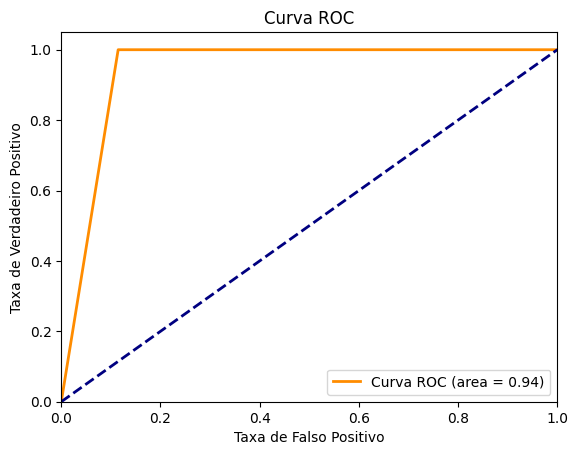

In [ ]:
model = RandomForestClassifier(n_estimators=1000, random_state=42, n_streams=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred)

precision_original = precision_score(y_test, y_pred)

recall_original = recall_score(y_test, y_pred)
recall_original_2 = recall_original**2

score_original = precision_original * recall_original_2
print(score_original)

print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plote a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
print('=' * 70)
print('=' * 70)

In [ ]:
# model = RandomForestClassifier(n_estimators=1000, random_state=42, n_streams=1)
# model.fit(X_train, y_train)

# # Calcule o ROC AUC score no conjunto de teste original
# y_pred = model.predict(X_test)

# precision_original = precision_score(y_test, y_pred)


# score_original = precision_original
# print(score_original)

# # Inicialize um array para armazenar as pontuações de importância de features
# feature_importances = np.zeros(X_train.shape[1])

# # Faça a permutação de cada feature e calcule o ROC AUC score
# for i in range(X_train.shape[1]):
#     X_test_permuted = X_test.copy()
#     np.random.shuffle(X_test_permuted[:, i])  # Permute a feature i
#     y_pred_permuted = model.predict(X_test_permuted)

#     precision_permuted = precision_score(y_test, y_pred_permuted)

#     recall_permuted = recall_score(y_test, y_pred_permuted)

#     if recall_permuted < 1:
#       score_permuted = score_original
#     else:
#       score_permuted = precision_permuted

#     feature_importances[i] = score_original - score_permuted

# # Ordene as features com base nas pontuações de importância
# sorted_feature_indices = np.argsort(feature_importances)[::-1]

# # Imprima as features em ordem decrescente de importância
# # for idx in sorted_feature_indices:
# #     print(f'Feature {idx}: {feature_importances[idx]}')

# # plt.bar(range(X_test.shape[1]),feature_importances[sorted_feature_indices])
# # plt.xticks(range(X_test.shape[1]), feature_names[sorted_feature_indices], rotation=90)
# # plt.xlabel('Features')
# # plt.ylabel('Importância por Permutação')
# # plt.show()

# for i in sorted_feature_indices:
#     print(f'{feature_names[i]:20} {feature_importances[i]:.4f}')
# # Remova as features menos importantes
# limite_importancia = -0.0007
# features_to_remove = [i for i in sorted_feature_indices if feature_importances[i] < limite_importancia]
# # X_train.drop(features_to_remove, axis=1, inplace=True)
# # X_test.drop(features_to_remove, axis=1, inplace=True)
# print(features_to_remove)
# X_test_filtered = np.delete(X_test, features_to_remove, axis=1)



In [ ]:
# model = RandomForestClassifier(n_estimators=1000, random_state=42, n_streams=1)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test_filtered)

# accuracy = accuracy_score(y_test, y_pred)
# confusion = confusion_matrix(y_test, y_pred)
# classification_rep = classification_report(y_test, y_pred)
# precision = precision_score(y_test, y_pred)

# precision_original = precision_score(y_test, y_pred)

# recall_original = recall_score(y_test, y_pred)
# recall_original_2 = recall_original**1

# score_original = precision_original * recall_original_2
# print(score_original)

# print(f'Precision: {precision}')
# print(f'Accuracy: {accuracy}')
# print(f'Confusion Matrix:\n{confusion}')
# print(f'Classification Report:\n{classification_rep}')


# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# # Plote a curva ROC
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Taxa de Falso Positivo')
# plt.ylabel('Taxa de Verdadeiro Positivo')
# plt.title('Curva ROC')
# plt.legend(loc="lower right")
# plt.show()
# print('=' * 70)
# print('=' * 70)

In [ ]:
# rfc = RandomForestClassifier(n_estimators=1000, random_state=42, n_streams=1)  # Você pode ajustar o número de árvores (n_estimators)

# # Treine o modelo no conjunto de treinamento
# rfc.fit(X_train, y_train)

# # Calcula a importância das features por permutação
# perm_importance = permutation_importance(rfc, X_test, y_test)

# # Plote a importância das features por permutação
# sorted_idx = perm_importance.importances_mean.argsort()[::-1]

# y_pred = rfc.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f'MSE: {mse}')
# plt.bar(range(X_test.shape[1]), perm_importance.importances_mean[sorted_idx])
# plt.xticks(range(X_test.shape[1]), feature_names[sorted_idx], rotation=90)
# plt.xlabel('Features')
# plt.ylabel('Importância por Permutação')
# plt.show()

In [ ]:
# rfc = RandomForestClassifier(n_estimators=1000, random_state=42, n_streams=1)

# feature_importance = perm_importance.importances_mean


# # Identifique as características a serem removidas
# features_to_remove = []
# for i, importance in enumerate(feature_importance):
#   if importance < -0.01:
#     features_to_remove.append(i)

# # Remova as características do conjunto de teste
# X_test_filtered = np.delete(X_test, features_to_remove, axis=1)

# rfc.fit(X_train, y_train)

# # Faça previsões no conjunto de teste filtrado
# y_pred = rfc.predict(X_test_filtered)

# # Avalie o desempenho com o novo modelo
# mse_filtered = mean_squared_error(y_test, y_pred)
# accuracy = accuracy_score(y_test, y_pred)

# print(f'Acurácia: {accuracy}')
# print(f'MSE com características filtradas: {mse_filtered}')
# print("==" * 50)

In [ ]:
pred = pd.DataFrame(y_pred)

In [ ]:
pred.describe()

,0
count,53462.000000
mean,0.115446
std,0.319563
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
rfc = RandomForestClassifier()
rfc.get_param_names()

['handle',
 'verbose',
 'output_type',
 'n_estimators',
 'max_depth',
 'handle',
 'max_features',
 'n_bins',
 'split_criterion',
 'min_samples_leaf',
 'min_samples_split',
 'min_impurity_decrease',
 'bootstrap',
 'verbose',
 'max_samples',
 'max_leaves',
 'accuracy_metric',
 'max_batch_size',
 'n_streams',
 'dtype',
 'output_type',
 'min_weight_fraction_leaf',
 'n_jobs',
 'max_leaf_nodes',
 'min_impurity_split',
 'oob_score',
 'random_state',
 'warm_start',
 'class_weight',
 'criterion']

In [ ]:
import optuna

In [ ]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 10, 1000)
  split_criterion = trial.suggest_int('split_criterion', 0, 1)
  bootstrap = trial.suggest_categorical("bootstrap", [True, False])
  max_samples = trial.suggest_float('max_samples', 0, 1)
  max_depth = trial.suggest_int('max_depth', 1, 10000)
  max_leaves = trial.suggest_int('max_leaves', -1, 10000)
  max_features = trial.suggest_float('max_features', 0, 1)
  n_bins = trial.suggest_int('n_bins', 1, 1024)
  min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.001, 10000, log=True)
  min_samples_split = trial.suggest_float('min_samples_split', 0.001, 10000, log=True)
  min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.001, 10000, log=True)
  random_state = trial.suggest_int('random_state', 1, 10000)
  if max_leaves == 0:
    max_leaves = 1

  if bootstrap == False:
    model = RandomForestClassifier(n_streams=1, n_estimators=n_estimators, split_criterion=split_criterion, bootstrap=bootstrap, max_depth=max_depth, max_leaves=max_leaves, max_features=max_features, n_bins=n_bins, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, min_impurity_decrease=min_impurity_decrease, random_state=random_state)
  else:
    model = RandomForestClassifier(n_streams=1, n_estimators=n_estimators, split_criterion=split_criterion, bootstrap=bootstrap, max_samples=max_samples, max_depth=max_depth, max_leaves=max_leaves, max_features=max_features, n_bins=n_bins, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, min_impurity_decrease=min_impurity_decrease, random_state=random_state)


  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  precision = precision_score(y_test, y_pred, zero_division=0)

  recall = recall_score(y_test, y_pred)

  if recall < 1:
    recall = 0

  score = precision * recall

  return score

In [ ]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)
study.optimize(objective, n_trials=10000, n_jobs=-1)

A saída de streaming foi truncada nas últimas 5000 linhas.
[I 2023-10-03 10:03:50,254] Trial 5000 finished with value: 0.0 and parameters: {'n_estimators': 551, 'split_criterion': 1, 'bootstrap': False, 'max_samples': 0.9683454622269096, 'max_depth': 7775, 'max_leaves': 4657, 'max_features': 0.10312835317735301, 'n_bins': 724, 'min_samples_leaf': 0.013489860385165319, 'min_samples_split': 0.004491165931318304, 'min_impurity_decrease': 0.003754369006558403}. Best is trial 4617 with value: 0.008636875704093128.
[I 2023-10-03 10:03:51,185] Trial 5001 finished with value: 0.0 and parameters: {'n_estimators': 915, 'split_criterion': 1, 'bootstrap': False, 'max_samples': 0.5091796366744578, 'max_depth': 7729, 'max_leaves': 4760, 'max_features': 0.10755905643940344, 'n_bins': 733, 'min_samples_leaf': 0.001701745350760908, 'min_samples_split': 0.10215081739153876, 'min_impurity_decrease': 0.008481132088201768}. Best is trial 4617 with value: 0.008636875704093128.
[I 2023-10-03 10:04:08,527] Tr

In [ ]:
best_params = study.best_params
best_score = study.best_value
print('Melhor hyperparâmetros: ', best_params)
print('melhor Score: ', best_score)

Melhor hyperparâmetros:  {'n_estimators': 695, 'split_criterion': 0, 'bootstrap': False, 'max_samples': 0.9672911016703517, 'max_depth': 4070, 'max_leaves': 8312, 'max_features': 0.8439008867799189, 'n_bins': 957, 'min_samples_leaf': 0.005146045222101435, 'min_samples_split': 0.0016802880374141445, 'min_impurity_decrease': 0.015408388312653544}
melhor Score:  0.010926365795724466


[W] [23:11:42.677254] If bootstrap sampling is disabled, max_samples value is ignored and whole dataset is used for building each tree
Precision: 0.011042944785276074
Accuracy: 0.9246006509296323
Confusion Matrix:
[[49386  4030]
 [    1    45]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     53416
         1.0       0.01      0.98      0.02        46

    accuracy                           0.92     53462
   macro avg       0.51      0.95      0.49     53462
weighted avg       1.00      0.92      0.96     53462



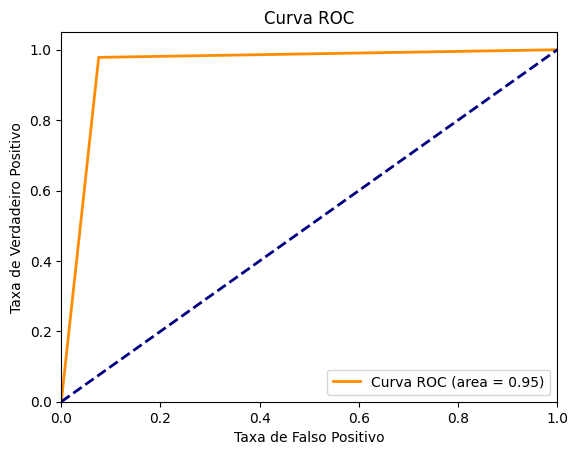

In [ ]:
model = RandomForestClassifier(n_streams=1, n_estimators= 906, split_criterion= 0, bootstrap= False, max_samples= 0.3994317971682374, max_depth= 158, max_leaves= 318, max_features= 0.833192616970997, n_bins= 151, min_samples_leaf= 0.00909751610935131, min_samples_split= 0.0038673434907006963, min_impurity_decrease= 0.015037322312696668)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plote a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
print('=' * 70)
print('=' * 70)

[W] [23:28:18.682112] If bootstrap sampling is disabled, max_samples value is ignored and whole dataset is used for building each tree
Precision: 0.012064343163538873
Accuracy: 0.931053832628783
Confusion Matrix:
[[49731  3685]
 [    1    45]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96     53416
         1.0       0.01      0.98      0.02        46

    accuracy                           0.93     53462
   macro avg       0.51      0.95      0.49     53462
weighted avg       1.00      0.93      0.96     53462



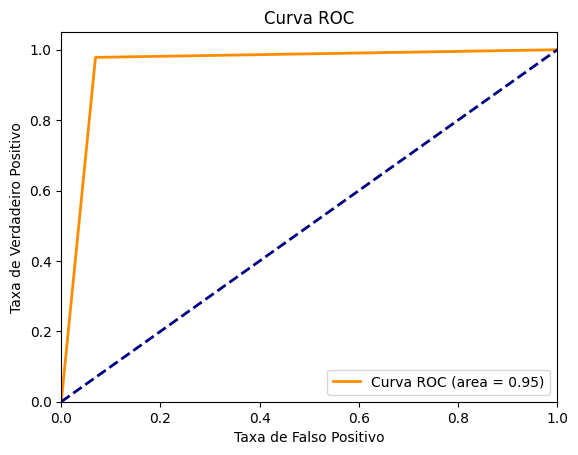

In [ ]:
model = RandomForestClassifier(n_streams=40, n_estimators= 695, split_criterion= 0, bootstrap= False, max_samples= 0.9672911016703517, max_depth= 4070, max_leaves= 8312, max_features= 0.8439008867799189, n_bins= 957, min_samples_leaf= 0.005146045222101435, min_samples_split= 0.0016802880374141445, min_impurity_decrease= 0.015408388312653544)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plote a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
print('=' * 70)
print('=' * 70)

model.convert_to_treelite_model().to_treelite_checkpoint('/')

In [ ]:
X_test.shape

(53462, 35)

In [ ]:
import pickle

In [ ]:
pickle.dump(model, open("RandomForestClassifier.pkl", "wb"))